In [34]:
import pandas as pd
import numpy as np
import itertools

In [35]:
# "Puxar" dados 7 dígitos fevereiro
consumos_7digitos_fevereiro = pd.read_csv(r"./dados/consumos_completos_fevereiro_cp_7_digitos.csv").drop(columns=["Unnamed: 0"])
consumos_7digitos_fevereiro["Código Postal 3 Dígitos"] = consumos_7digitos_fevereiro["Código Postal"].str.split("-").str[1]
consumos_7digitos_fevereiro.head()

,Código Postal,Energia ativa (kWh),Hora,Código Postal 4 Dígitos,Código Postal 3 Dígitos,Dia
0,3000-003,32.061177,0,3000,003,02-01
1,3000-003,26.345827,1,3000,003,02-01
2,3000-003,24.484873,2,3000,003,02-01
3,3000-003,22.702250,3,3000,003,02-01
4,3000-003,20.844550,4,3000,003,02-01


In [36]:
# "Puxar" dados 4 dígitos normalizados
consumos_4digitos_normalizados = pd.read_csv(r"./dados/consumo_diario_normalizado_cp4digitos.csv").drop(columns=["Unnamed: 0"])
consumos_4digitos_normalizados.head()

,Código Postal,Dia_MM_DD,Valor_Normalizado
0,3000,01-01,0.641843
1,3000,01-02,0.778192
2,3000,01-03,0.967029
3,3000,01-04,1.009368
4,3000,01-05,1.032455


In [37]:
# Gerar todos os pares de dia-mês (exceto 29/02)
all_days = pd.date_range("2025-01-01", "2025-12-31", freq='D')
all_days = all_days[~((all_days.month == 2) & (all_days.day == 29))]  # remover 29/02
all_day_strings = all_days.strftime("%m-%d")

# Gerar todas as combinações Dia, Hora
all_hours = list(range(24))
all_day_hour_combinations = list(itertools.product(all_day_strings, all_hours))

# Obter todos os códigos postais únicos
codigos_postais = consumos_7digitos_fevereiro["Código Postal"].unique()

# Criar dataframe completo de referência
full_index = pd.MultiIndex.from_product(
    [codigos_postais, all_day_strings, all_hours],
    names=["Código Postal", "Dia", "Hora"]
)
df_base = pd.DataFrame(index=full_index).reset_index()

# Extrair valores de 10 de fevereiro
feb_10 = consumos_7digitos_fevereiro[consumos_7digitos_fevereiro["Dia"] == "02-10"]

# Juntar com base para cada código postal
df_base = df_base.merge(
    feb_10[["Código Postal", "Hora", "Energia ativa (kWh)"]],
    on=["Código Postal", "Hora"],
    how="left",
    suffixes=("", "_feb10")
)

# Adicionar coluna "Código Postal 4 Dígitos"
df_base["Código Postal 4 Dígitos"] = df_base["Código Postal"].str[:4]

# Converter para string ambos os lados do merge
df_base["Código Postal 4 Dígitos"] = df_base["Código Postal"].str[:4]
consumos_4digitos_normalizados["Código Postal"] = consumos_4digitos_normalizados["Código Postal"].astype(str)

# Juntar com normalização
df_base = df_base.merge(
    consumos_4digitos_normalizados,
    left_on=["Código Postal 4 Dígitos", "Dia"],
    right_on=["Código Postal", "Dia_MM_DD"],
    how="left",
    suffixes=("", "_norm")
)

# Calcular energia estimada
df_base["Energia ativa (kWh)"] = df_base["Energia ativa (kWh)"] * df_base["Valor_Normalizado"]

# Selecionar colunas finais
df_resultado = df_base[["Código Postal", "Dia", "Hora", "Energia ativa (kWh)"]]

# Se desejar, você pode agora concatenar este com os dados reais de fevereiro
# consumos_completos = pd.concat([consumos_7digitos_fevereiro, df_resultado[~...]])


In [38]:
df_resultado.head()

,Código Postal,Dia,Hora,Energia ativa (kWh)
0,3000-003,01-01,0,17.830388
1,3000-003,01-01,1,18.472971
2,3000-003,01-01,2,16.846703
3,3000-003,01-01,3,16.743939
4,3000-003,01-01,4,15.158303


In [40]:
df_resultado["Código Postal"].unique()

array(['3000-003', '3000-005', '3000-007', ..., '3060-853', '3060-855',
       '3060-857'], shape=(1325,), dtype=object)

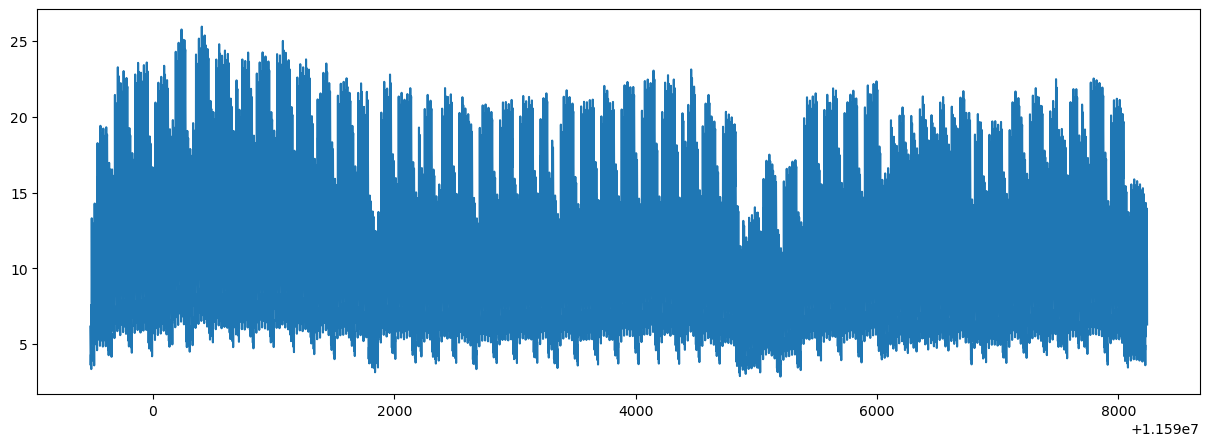

In [46]:
import matplotlib.pyplot as plt

# Separar um código postal aleatório
df_cp = df_resultado[df_resultado["Código Postal"] == "3060-855"]

# Plotar os dados
plt.figure(figsize=(15, 5))

# Plotar dados reais (setembro e novembro)
plt.plot(df_cp["Energia ativa (kWh)"])
plt.show()

In [44]:
df_resultado.to_csv(r"./dados/consumos_horarios_7digitos_anotodo.csv")